## Notes
### 02/09/18 [12:00]
Here are some notes after "finishing training".  
To kick things off, each epoch took aproximately 2h20min to train, in my personal Ubuntu. It isn't the greatest of machines, but I was able to get some very impressive results after 5 epochs:  
_Test loss: 1.4660126214812637  
Test accuracy: 0.8552342583948307_  
  
The lengthy duration of each epoch is the reason for why I didn't continue training for more epochs. And also the fact that python got to the point of consuming 1GB of RAM, making my computer downright unusable.  
Given that, the model results were saved after those 5 epochs.  
One of the reasons for such a long training time is that using 2d convolution makes it so that the model has way more trainable parameters, and I mean it:  
_Total params: 9,770,188  
Trainable params: 9,770,188  
Non-trainable params: 0_  
  
Also, something that I found during my research is this contrib feature: https://www.tensorflow.org/api_docs/python/tf/contrib/data/sliding_window_batch  
I'm not entirely sure of how to use it, but it might prove itself very useful if I ever need to train a network on some fixed data, so the network itself should do the sliding window data preparation.  
  
That being said, I'm happy with the obtained results. And as a last note, it's noticeable that the model began calibrating less and less after time, and I believe that is due to the optimizer used, the _Adadelta_, which has a adaptive momentum implementation. I speculate that using a SGD, this model could have reached accuracy close to the 90%-95% range within the same 5 epochs.  
  
### 01/09/18 [14:00 - 14:30]
As I mentioned in the last note, I tried implementing a 2d Convolution over the word Embeddings, almost as if they were images.  
To do so, I added a Reshape layer between the Embedding_1 and Conv1d_1, in which the final shape was (batch_size, window_size, embedding_dimensionality, 1). After that, I changed the 1d convolutions to 2d, changing the kernel_size from 3 to (3,3). With that, I can now explain the the addition of an apparently useless new dimensionality to the input vector after Reshape, and I can confirm that it is indeed useless. I mean, kinda. What it does is that conv2d requires a 4d input, with one of the dimensionalities being number of channels. So all that Reshape_1 does is that it includes a new "null" dimension that is treated as the number of channels, so that we can do spatial convolution on the Embeddings. 
And the results appear to be clear from the very start. I've only ran half an epoch so far, but accuracy results appear promising.  

### 12/08/18 [07:45 - 13:20]
So yeah, I might have done a mistake or two in the last implementation.... Between them, not realising that the input to Conv1D has a lot of channels and that I ~~could~~ should use a lot of filters.  
But that's all in the past, now that this little boy is up and learning and growing in a healthy manner.  
Now the first Conv1D uses 5 filters and the second one, 3. I could perhaps increase this someday.  
Not only that, but now it also saves it weights during training (I had done this in another implementation, but I forgot to commit that one, so now it's in this one).  
And now on to some notes for my future self, I was asing myself if it would be possible to get the 16 dimensional vector produced by Embedding and use Conv2D on it. It seems to be possible with the aid of keras.layers.Reshape. The idea would be to simply add a single dimension to the end of Embedding, so it would become 4D, allowing it to be used as input to Conv2D. I might do that in a separate file though, so that I'm able to compare both results.
Another possible improvement might be to shuffle the data. I didn't do so because there data order is relevant in this data set, but who knows what might happen?  
Also, here goes a complete log of the changes, in chronological order:
- Changed the parameter filter in the first Conv1D to 5
- Changed the parameter filter in the second Conv2D to 3
- Changed metrics to 'acc', as there is no implementation of sparse_categorical_accuracy in tf.keras
- Added saving cell, with model.save_weights
- Added ModelCheckpoint callback, saving only weights
- Added model saving to saving cell
- Changed the ModelCheckpoint parameter save_only_weights to False, as to resume training in later ocasions
- Also, increased periods in ModelCheckpoint
- Changed the checkpoint path to include data and time of checkpoint
- Gave names to the layers
- Added loading model cell  

On a side note, loss just went nuts


### Some time in the past:
I have yet to conclude training the model, but I was to excited to share it finally working after a long time.  
On a side note, however, it does seem to overfit before the end of even the first epoch, but we need to conclude a whole training session before jumping to any conclusions


# Word Prediction using TDNN implemented in tf.keras
This notebook is an attempt at implementing a Time Delay Neural Network for word prediction in the ptb dataset

In [118]:
# Imports
from __future__ import print_function
import tensorboard as tb
from tensorflow import keras
import reader
import numpy as np
import os
from time import strftime, gmtime
import pathlib
from pathlib import PosixPath
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy import stats
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Constants
window_size = 20 # defines the past lookup for determining the following word
path = "data/simple-examples/data"
checkpoint_path = "training/conv2d/cp-{epoch:04d}_" + strftime("%H-%M_%d-%m-%Y", gmtime()) + ".ckpt"
checkpoint_dir = os.path.dirname

The following cell obtain the data using the reader.py file

In [3]:
train_data, valid_data, test_data, vocab_size, word_to_id = reader.ptb_raw_data(path)
x_train = train_data[:-1]
x_train = [np.asarray(x_train[i:i+window_size]) for i in range(len(x_train)-window_size)]
x_train = np.asarray(x_train)
y_train = np.asarray(train_data[1:-window_size])
#y_train = keras.preprocessing.text.one_hot(y_train, vocab_size)
x_valid = valid_data[:-1]
x_valid = [np.asarray(x_valid[i:i+window_size]) for i in range(len(x_valid)-window_size)]
x_valid = np.asarray(x_valid)
y_valid = valid_data[1:-window_size]
y_valid = np.asarray(y_valid)
x_test = test_data[:-1]
x_test = [np.asarray(x_test[i:i+window_size]) for i in range(len(x_test)-window_size)]
x_test = np.asarray(x_test)
y_test = test_data[1:-window_size]
y_test = np.asarray(y_test)
id_to_word = {value: key for (key, value) in word_to_id.items()}

Following next, we have an auxiliary function which decodes the ids and give us the original sentences

In [4]:
def decode_text(text):
    return ' '.join([id_to_word.get(i, '?') for i in text])

In [5]:
decode_text (x_train[40])

'<eos> mr. <unk> is chairman of <unk> n.v. the dutch publishing group <eos> rudolph <unk> N years old and former'

In [6]:
print(x_train.shape)
print(y_train.shape)

(929568, 20)
(929568,)


As we can see, each index of the input has a length of 20 words, as defined in _window-length_
<br>
With our data already processed, we can finally create our model.

In [7]:
# First time instantiation
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_length = window_size, name = "Embedding_1"))
#model.add(keras.layers.Flatten())
model.add(keras.layers.Reshape((10,16,1), name = "Reshape_1"))
model.add(keras.layers.Conv2D(filters = 3, kernel_size = (3,3), padding = "same", activation = keras.activations.tanh, name = "Conv2D_1"))
model.add(keras.layers.Dropout(0.2, name = "Droupout_1"))
model.add(keras.layers.Conv2D(filters = 2, kernel_size = (3,3), padding = "same", activation = keras.activations.tanh, name = "Conv2D_2"))
model.add(keras.layers.Dropout(0.25, name = "Dropout_2"))
model.add(keras.layers.Flatten(name = "Flatten_1"))
model.add(keras.layers.Dense(vocab_size, activation = keras.activations.softmax, name = "Dense_1"))

In [4]:
# Model loading - loads the most recent model recorded manually. Feel free to change
# Sort the checkpoints by modification time.
#checkpoints = pathlib.Path("./models").glob("*")
checkpoints = pathlib.Path("./models/").glob("*")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])
checkpoints
model = keras.models.load_model(latest)

e:\wpy-3661\notebooks\tdnn-asr\env\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [5]:
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_1 (Embedding)      (None, 20, 16)            160000    
_________________________________________________________________
Reshape_1 (Reshape)          (None, 20, 16, 1)         0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 20, 16, 5)         50        
_________________________________________________________________
Droupout_1 (Dropout)         (None, 20, 16, 5)         0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 20, 16, 3)         138       
_________________________________________________________________
Dropout_2 (Dropout)          (None, 20, 16, 3)         0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 960)               0         
__________

In [6]:
model.compile(
    loss = keras.losses.sparse_categorical_crossentropy,
    optimizer = keras.optimizers.SGD(),
    metrics = ['acc'] #keras.metrics.categorical_accuracy] # remember to later change to sparse_categorical_accuracy (this is the cause for strange eval)
)

In [7]:
# Checkpoint callback
cp_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose = 1, save_weights_only = False, period = 3) # Also, later change to save_weights_only = false, and perhaps increase period to 3 or 4. This will allow us to later resume training from where we left

In [18]:
model.fit(x_train, y_train,
          epochs = 12,
          verbose = 1,
          validation_data = (x_valid, y_valid),
          shuffle = False,
          callbacks = [cp_callback]
)

e:\wpy-3661\notebooks\tdnn-asr\env\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 929568 samples, validate on 73739 samples
Epoch 1/12
   672/929568 [..............................] - ETA: 1:07:23 - loss: 1.7953 - acc: 0.7827

KeyboardInterrupt: 

In [ ]:
# I expect to be able to run this someday
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [37]:
model.save_weights("./model_weights/conv2d_weights_" + strftime("%H-%M_%d-%m-%Y", gmtime()))
model.save("./models/conv2d_model_" + strftime("%H-%M_%d-%m-%Y", gmtime())) # This allows us to resume training, since Adadelta has adaptive parameters

In [14]:
inp = model.input                                           # input placeholder
#outputs = [layer.output for layer in model.layers]          # all layer outputs
outputs = [model.layers[2].output, model.layers[4].output]
functor = keras.backend.function([inp]+ [keras.backend.learning_phase()], outputs ) # evaluation function
mask = [np.random.randint(0, 1600, 50), np.random.randint(0, 960, 50)]
print (mask[0])

[1239  710  781  266  414  533  514   40 1159 1007 1392  840   24 1323
 1387  155 1380 1077  716  788  972 1358  216 1085 1355  389  216 1150
 1588  744  739 1143  965  362  665 1567 1403  975  509  938 1379 1403
  374  748  889 1354  900  446  701 1343]


In [66]:
# Testing
layer_outs = list()
results1 = list()
results2 = list()
for test in range(500):
    #print (test)
    layer_outs = functor([[x_test[test]], 1.])
    layers = list()
    for i in range(len(layer_outs)):
        layer = layer_outs[i]
        layer = np.hstack(layer)
        layer = np.hstack(layer)
        layer = np.hstack(layer)
        output = layer[mask[i]]
        results1.append(output) if i == 0 else results2.append(output)
results1 = np.asarray(results1)
results2 = np.asarray(results2)
print(results1)
print(results1.shape)

[[-0.9723883  -0.99995893  0.9550044  ... -0.21607855  0.9943161
   0.9106723 ]
 [-0.9800286  -0.78755623  0.84456944 ...  0.94381845 -0.9756971
  -0.27614653]
 [ 0.8961085  -0.9966171   0.9983294  ...  0.9871406   0.95904016
  -0.8710535 ]
 ...
 [-0.96465707 -0.89332     0.8768315  ...  0.90055066  0.30913404
   0.4532876 ]
 [ 0.89785236 -0.9933317   0.836221   ...  0.9969585  -0.4781781
   0.49241164]
 [-0.6216497  -0.999377    0.97339404 ...  0.9993931  -0.9057351
  -0.46476623]]
(500, 50)


In [15]:
#results1 = results1.transpose()
hist = [np.histogram(x, bins=50, density=True, range=(-1,1))[0] for x in results1.transpose()]
hist = np.asarray(hist)
hist = hist.transpose()
print(hist.shape)

(50, 50)


In [16]:
print(hist[1])

[2.1  1.5  3.05 1.4  1.75 0.7  1.15 2.   1.7  1.95 1.   5.9  1.55 1.5
 1.1  0.7  1.95 1.9  1.75 1.3  0.   2.   2.15 1.45 0.3  5.9  0.8  1.65
 0.35 2.35 1.7  1.4  1.8  2.1  1.9  0.9  0.8  0.   1.45 1.4  1.5  0.25
 1.   1.25 1.85 0.95 1.7  2.3  0.25 1.95]


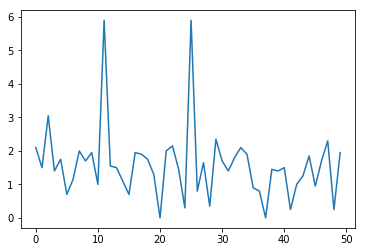

In [17]:
plt.plot(hist[1])
plt.show()

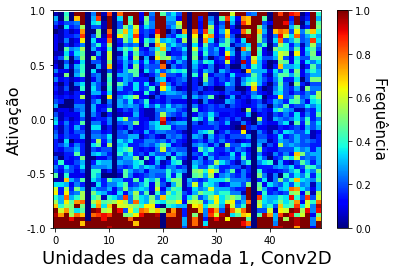

In [121]:
ax = plt.imshow(hist, cmap=matplotlib.cm.jet, vmin=0, vmax=1, aspect = "auto", interpolation=None)
cbar = plt.colorbar()
cbar.set_label('Frequência', rotation=270, labelpad=15, size=15)
cbar.labelpad = 70
#ax.set_xticklabels(["0","0.2","0.4","0.6","0.8","1"])
#ax.suptitle('test title', fontsize=20)
ax.axes.invert_yaxis()
ax.axes.set_yticklabels(np.arange(-1.0,1.1,.5))
plt.yticks(np.arange(0, 51, 12.5))
plt.ylim(0,50)
#ax.axes.tick_params("y", labeltop=True)
#ax.axes.bar(np.arange(-1.,1.,0.5), 5, width=0.8, align='center')
#ax.axes.set(yticks=np.arange(-1.,1.,0.5), xlim=[-1, 10])
ax.axes.margins(y=0, x=0)
plt.xlabel('Unidades da camada 1, Conv2D', fontsize=18)
plt.ylabel('Ativação', fontsize=16)
plt.show()

In [190]:
def plot_activations_freq(data, xlabel, ylabel, cbar=False, cbarlabel=None, cmap=matplotlib.cm.jet, bins=50, range=None,
                         hist_transpose=True, file=None, tick_label_amnt=5, interpolation=None, invert_yaxis=True):
    hist = [np.histogram(x, bins=50, density=True, range=(-1,1))[0] for x in data.transpose()]
    hist = np.asarray(hist)
    if hist_transpose:
        hist = hist.transpose()
    ax = plt.imshow(hist, cmap=cmap, vmin=0, vmax=1, aspect = "auto", interpolation=interpolation)
    if cbar:
        cbar = plt.colorbar()
        if cbarlabel is not None:
            cbar.set_label(cbarlabel, rotation=270, labelpad=15, size=15)
            cbar.labelpad = 70
    if invert_yaxis:
        ax.axes.invert_yaxis()
    ax.axes.set_yticklabels(np.arange(-1.0,1.1,2/(tick_label_amnt-1)))
    plt.yticks(np.arange(0, len(data[0]) + 1, len(data[0])/(tick_label_amnt-1)))
    plt.ylim(0,len(data[0]))
    #ax.axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    #ax.axes.tick_params("y", labeltop=True)
    #ax.axes.bar(np.arange(-1.,1.,0.5), 5, width=0.8, align='center')
    #ax.axes.set(yticks=np.arange(-1.,1.,0.5), xlim=[-1, 10])
    #x.axes.margins(y=0, x=0
    plt.xlabel('Unidades da camada 1, Conv2D', fontsize=18)
    plt.ylabel('Ativação', fontsize=16)
    plt.show()

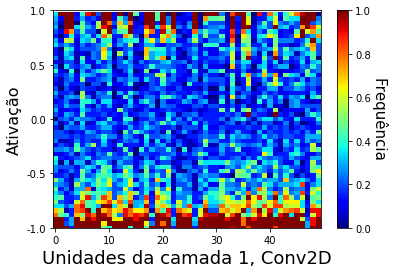

In [191]:
plot_activations_freq(results1, "Ativações", "Unidades da camada 1, Conv2D", cbar=True, cbarlabel="Frequência")

In [179]:
plot_activations_freq(results2)

TypeError: plot_activations_freq() missing 2 required positional arguments: 'xlabel' and 'ylabel'